In [2]:
import os
import glob
import json
from numpy import genfromtxt
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
def cleanfile(root, fn):
    newfn = root + fn[:-3] + ".cln.txt"
    
    with open(newfn, "w") as f:
        lines = open(root+fn, "r").readlines()
        f.write(lines[0])
        
        for line in lines[1:]:
            tokens = line.split()
            newline = ""
            for t in tokens:
                if "variable" in t:
                    newline += t[9:-1]
                else:
                    newline += t
                    
                newline += "\t"
                
            newline += "\n"

            f.write(newline)
            
    return newfn

In [40]:
def plot_curves(files, title, labeler, xlim=15000, mtn=True, entropy=0, plot_only=None, e_index=-3, smooth=1, ylim=-1, plot=True, alllabel=None):
    alldata = []
    
    if plot:
        plt.figure(figsize=(15, 10))
        
    plt.title(title)
    
    for f in files:
        try:
            job_id = int(f.split("/")[1])
        except:
            job_id = -1
            #continue
            
        jobdir = "/".join(f.split("/")[:-1]) + "/"
    
        with open(jobdir + "command.txt", "r") as f:
            com = f.readlines()
            
        args = json.load(open(jobdir + "args.txt", "r"))
        
        label = labeler(job_id, com, args)
        
        if label is None:
            continue
        
        data = genfromtxt(jobdir + 'scores.txt', delimiter='\t', skip_header=1)

        if len(data.shape) < 2:
            continue
        steps = data[:, 0]
        means = None
        
        if entropy > 0:
            a = (data.shape[1] == 27 or data.shape[1] == 18 or data.shape[1] == 13)
            if not a:
                means = [0]
            
            if entropy == 1and a:
                if a:
                    means = data[:, e_index]
                    #print(job_id, means)
                else:
                    continue
            elif entropy == 2 and a:
                if data.shape[1] == 27:
                    means = data[:, -4]
                else:
                    continue
        else:
            means = data[:, 3]

        #plt.plot(data[:, 0], data[:, 3])
        alldata.append([label, job_id, steps, means])
        
    types = list(set([d[0] for d in alldata]))
    types.sort()
    
    for i, t in enumerate(types):
        allmeans = []
        
        for label, job, steps, means in alldata:
            if label == t and means is not None:
                allmeans.append(means)
                s = steps
        
        if len(allmeans) <= 0:
            continue
        
        minlen = min([len(m) for m in allmeans])
        allmeans = [m[:minlen] for m in allmeans]
        
        allmeans = np.array(allmeans)
        
        #allmeans = allmeans[np.argsort(allmeans[:, -1])[-5:]]
        
        means = np.mean(allmeans, axis=0)
        stds = np.std(allmeans, axis=0)
        
        t += " {" + str(len(allmeans)) + "}"
        
        if entropy > 0:
            plt_fn = plt.plot
        else:
            plt_fn = plt.plot
        
        if plot_only is not None and i not in plot_only:
            continue
        
        ls = '-'
        if 'noisy nets' not in t or 'coef:1' not in t:
            ls = '--'
            
        if smooth > 1:
            import pandas as pd
            means = pd.rolling_mean(means, smooth)
            
        if alllabel:
            t = alllabel
            
        p = plt_fn(s[:minlen], means, label=t, ls=ls)
        
        for mean in allmeans:
            plt_fn(s[:minlen], mean, color=p[0].get_color() + "20")
        #plt.fill_between(s[:minlen], means-stds, means+stds, color=p[0].get_color() + "20")
    
    if mtn:
        plt.plot([0, 1000000], [-110, -110], lw=2, ls="--")
    plt.xlim((0, xlim))
    if ylim > 0:
        plt.ylim((0, ylim))
    plt.xlabel("steps")
    
    if plot:
        plt.legend()
        plt.show()

In [5]:
def labeler_fn2(dqn, repeat, start_job, env, end_job=None):
    def labeler(job, com, args):
        #print(com)
        if job < start_job:#130841:#127346:#127286:#126608:#125890:
            return None
        if end_job is not None and job > end_job:
            return None

        com = com[0]
        
        if "dueling" in com:
            if job >= 136867:
                label = ""#"DuelDQN"
            else:
                if job <= 136146:
                    label = "DuelDQN"
                else:
                    label = "DuelDQN fixedinit"
        else:
            #label = "DQN"
            label = ""
            #return None
        
        if job >= 133146 and job <= 133155:
            return None
        
        if job >= 133650 and job <= 133659:
            label += " fixedinit"
            
        if job >= 133595 and job <= 133604:
            #label += " ablation"
            return None
            
        if job >= 133640 and job <= 133649:
            label += " fixedinit"
            
        if job >= 139134 and job <= 139143:
            label += " new"
            
        if job >= 186214 and job <= 186216:
            label += " b:1/sqrt(out) "
        if job >= 186208 and job <= 186210:
            label += " b:0.017 "
        if job >= 186224 and job <= 186226:
            label += "mub"
            
        if 'prop' in args and args['prop']:
            label += " prop"
            #print(job)
            return None
            
        if job >= 139264:
            #label += "new"
            pass
            
        #if args['agent'] != 'SARSA':
        #    return None
        
        label += args['agent']
            
        if env not in args['env']:
            return None
        
        if 'noise_coef' in args:
            label += " coef:" + str(args['noise_coef'])
            
        if 'init_method' in args:
            label += " init:" + str(args['init_method'])
        
        if 'last_noise' in args and args['last_noise'] > 0:
            label += " last"
        
        if 'entropy_coef' in args:
            if args['entropy_coef'] > 0:
                #return None
                label += " ec: " + str(args['entropy_coef'])
                #return None
                
        #label += " bs:" + str(args['minibatch_size'])
        #label += " rb:" + str(args['buffer_size'])
        
        if 'orig_noise' in args and args['orig_noise']:
            label += ' orig'
            return None
        
        if args['noisy_net_sigma'] and args['noise_constant'] > 0:
            label += " constant noise (sigma = " + str(args['noise_constant']) + ")"
        elif args['noisy_net_sigma'] and args['noisy_net_sigma'] > 0:
            label += " noisy nets (sigma0 = " + str(args['noisy_net_sigma']) + ")"
        else:
            label += " finexp:" + str(args["final_exploration_frames"])
        
        print(job, args['init_method'], args['noise_coef'], args['entropy_coef'])
        
        return label

    return labeler

#start = 133126#131653
#plot_curves(glob.glob("results/*/*/scores.txt"), "AsterixDeterministic-v4 DQN&DuelDQN",
#            labeler_fn2(True, 1, start, 'Asterix'), 55000000, mtn=False)

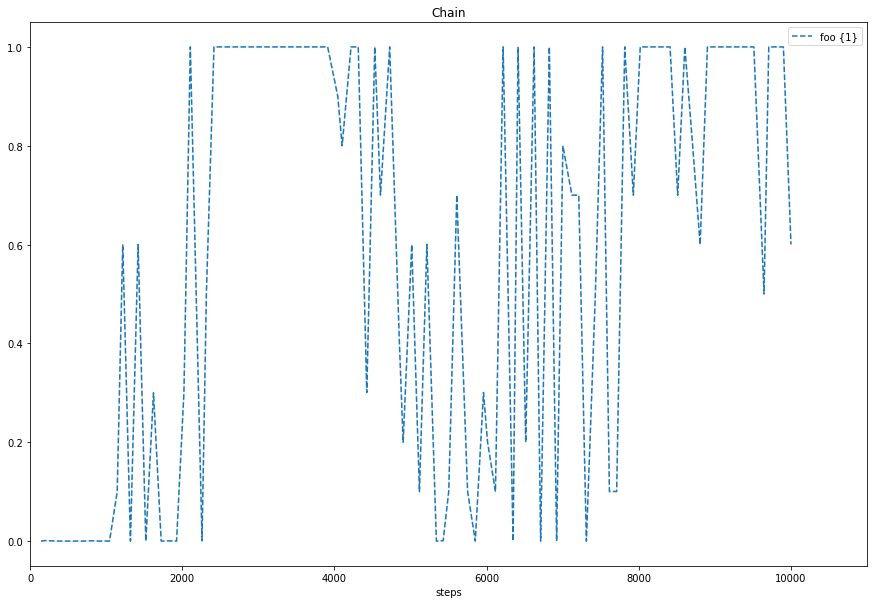

In [49]:
path = "results/20180730T094343.084086/scores.txt"
plot_curves(glob.glob(path), "Chain",
            lambda x, y, z: 'foo', 11000, mtn=False, entropy=0)

In [56]:
def plot_entropy(path):
    plt.figure(figsize=(15, 10))
    plot_curves(glob.glob(path), "Chain",
                lambda x, y, z: 'foo', 11000, mtn=False, entropy=1, e_index=-1, plot=False, alllabel='final')
    plot_curves(glob.glob(path), "Chain",
                lambda x, y, z: 'foo', 11000, mtn=False, entropy=1, e_index=-2, plot=False, alllabel='penultimate')
    plot_curves(glob.glob(path), "Chain",
                lambda x, y, z: 'foo', 11000, mtn=False, entropy=1, e_index=-3, plot=False, alllabel='first')
    plt.legend()
    plt.show()

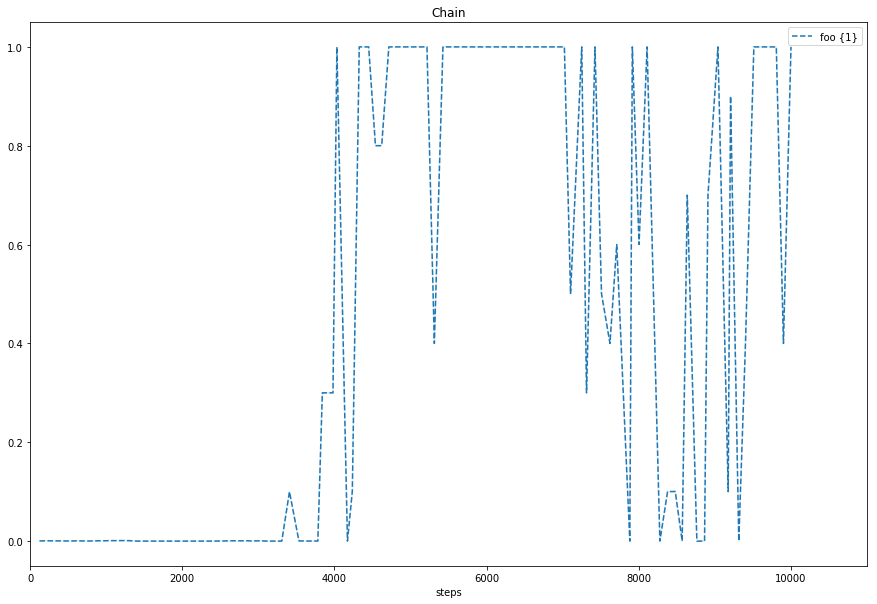

In [52]:
path = "results/20180730T095347.109790/scores.txt"
plot_curves(glob.glob(path), "Chain",
            lambda x, y, z: 'foo', 11000, mtn=False, entropy=0)

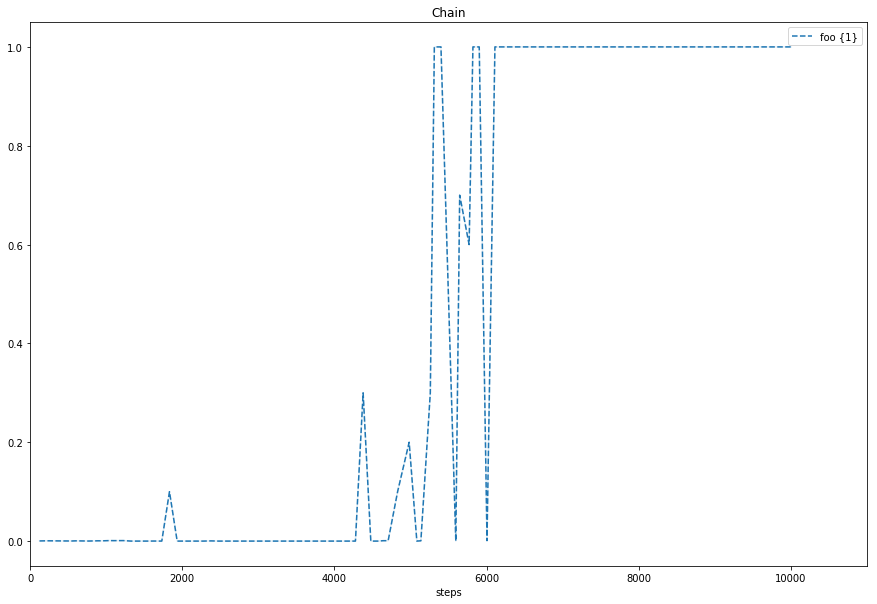

In [53]:
path = "results/20180730T095648.459771/scores.txt"
plot_curves(glob.glob(path), "Chain",
            lambda x, y, z: 'foo', 11000, mtn=False, entropy=0)

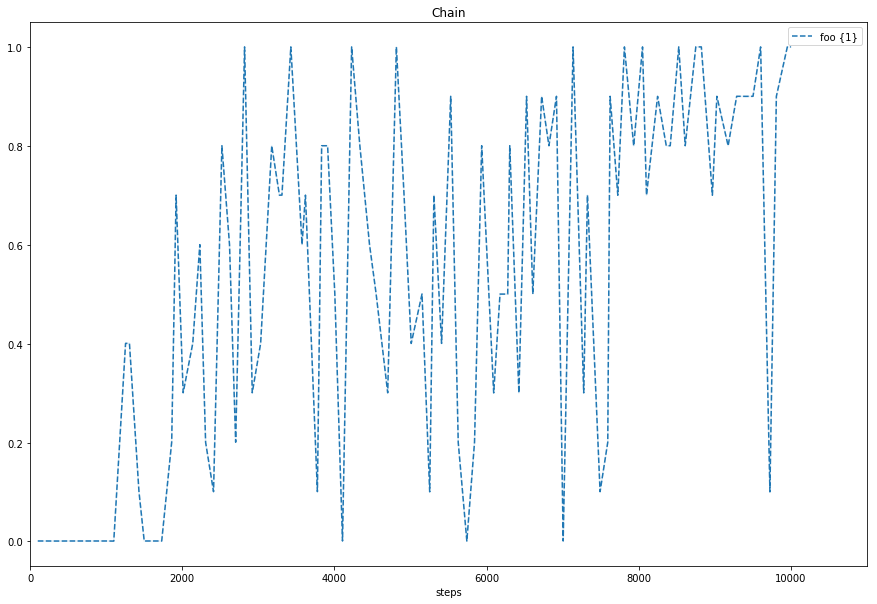

In [60]:
path = "results/20180730T100011.273604/scores.txt"
plot_curves(glob.glob(path), "Chain",
            lambda x, y, z: 'foo', 11000, mtn=False, entropy=0)

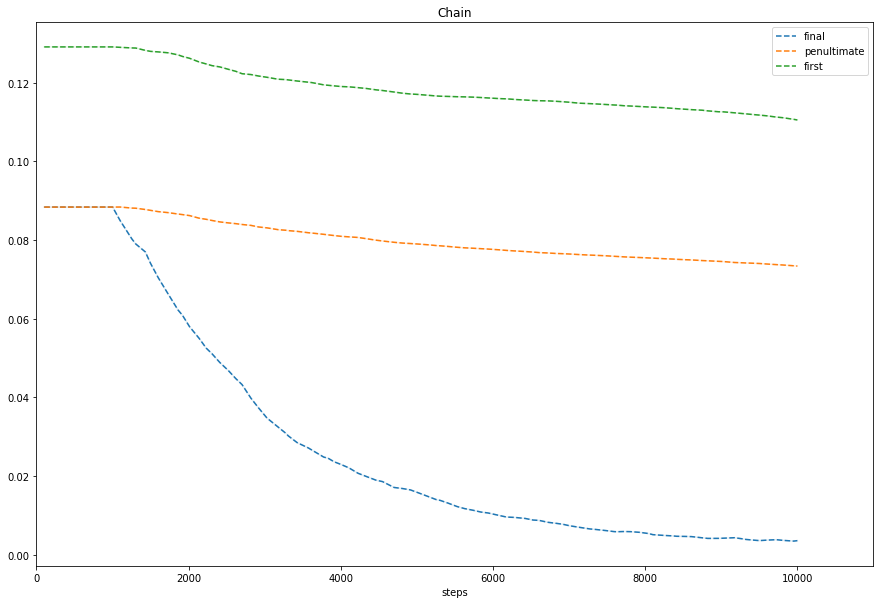

In [61]:
plot_entropy(path)

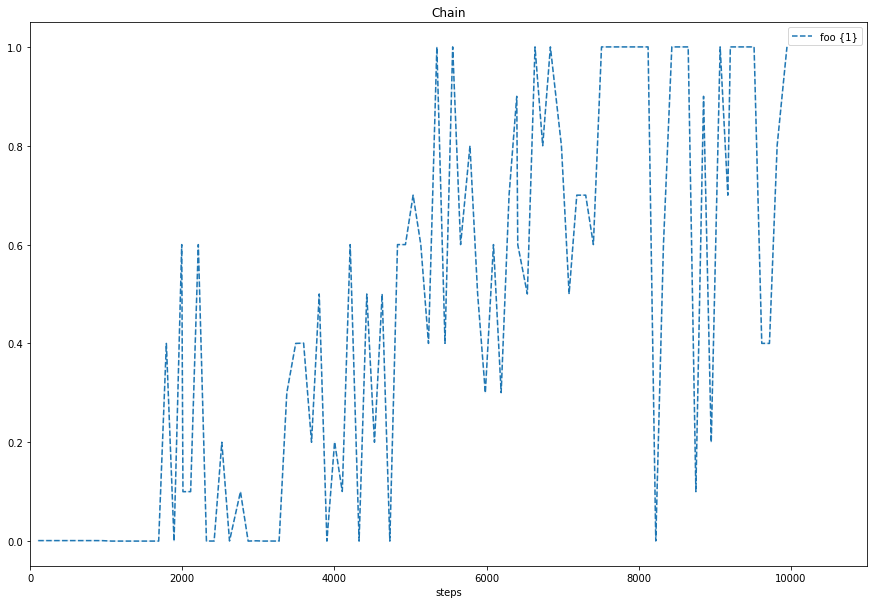

In [77]:
path = "results/20180730T105228.567225/scores.txt"
plot_curves(glob.glob(path), "Chain",
            lambda x, y, z: 'foo', 11000, mtn=False, entropy=0)

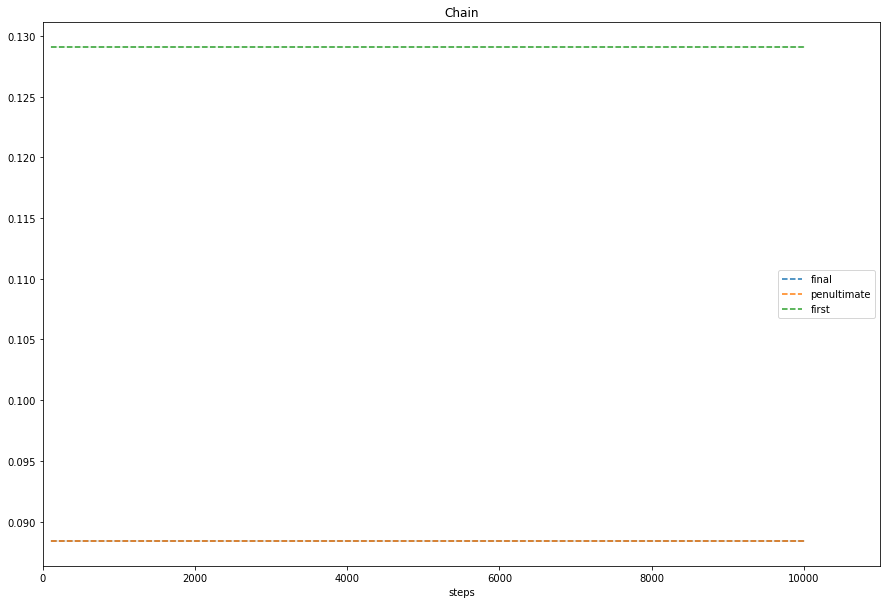

In [78]:
plot_entropy(path)